# Author Information

**Author:** CHUA JINGXUAN

**Taylor's Student ID:** 0365376

**Email:** 0365376@sd.taylors.edu.my

**Note:** This Jupyter Notebook was written by CHUA JINGXUAN. If you find any issues, have questions, or want to provide feedback, please don't hesitate to reach out. Thank you for exploring this notebook!

**Date Written**: 28/07/2024 (SUN)

**Last Updated**: 30/07/2024 (TUE)

---
# ITS70804 Text and Image Processing: ASSIGNMENT 3
---

# Trial 06: DenseNet12 Pre-trained on CIFAR10 (Teacher) + DeiT-Tiny (Student)

# Importing Essential Libraries

In [ ]:
!pip install timm

In [ ]:
# !git clone https://github.com/huyvnphan/PyTorch_CIFAR10.git

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torchvision.models as models
import timm
import time
from sklearn.metrics import classification_report, accuracy_score

C:\Users\Chris\.conda\envs\torch_con\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1.0 Data Loading and Apply Augmentation

In [ ]:
from torch.utils.data.dataset import random_split

def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images for DeiT input
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),  # Normalize for CIFAR-10
    ])

# Loading CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=get_transforms())
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Get the test dataset
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=get_transforms())

# Split the test dataset into validation and test datasets
val_size = len(test_dataset) // 2  # Half of the test dataset
test_size = len(test_dataset) - val_size

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Create the validation and test loaders
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# 2.0 Instantiate Teacher and Student Model

In [ ]:
# from PyTorch_CIFAR10.cifar10_models.densenet import densenet121

In [ ]:
from densenet import densenet121

In [ ]:
# Initialize the teacher model (DenseNet121)
teacher_model = densenet121(pretrained=True)
teacher_model = teacher_model.eval()

# Initialize the student model (DeiT Tiny)
student_model = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=10)
student_model.train()

# Move the teacher model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = teacher_model.to(device)
student_model = student_model.to(device)

# Function to count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters
teacher_params = count_parameters(teacher_model)
student_params = count_parameters(student_model)
print(f"Number of parameters in teacher model (DenseNet121): {teacher_params}")
print(f"Number of parameters in student model (DeiT Tiny): {student_params}")

Number of parameters in teacher model (DenseNet121): 6956426
Number of parameters in student model (DeiT Tiny): 5526346


In [ ]:
# print(teacher_model)

# 3.0 Define Loss Function and Optimizer

In [ ]:
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.0005)  # Smaller learning rate for fine-tuning

def distillation_loss(student_output, teacher_output, labels, T=3.0):
    soft_loss = F.kl_div(F.log_softmax(student_output/T, dim=1), F.softmax(teacher_output/T, dim=1), reduction='batchmean')
    hard_loss = F.cross_entropy(student_output, labels)
    return soft_loss + hard_loss

temperature = 3.0  # Temperature for softening probabilities

# 4.0 Model Training Loop and Timing

In [ ]:
# Number of epochs
num_epochs = 50

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    student_model.train()  # Set the student model to training mode
    total_loss = 0
    train_correct = 0
    train_total = 0
    start_time = time.time()  # Start timing the epoch

    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through teacher model
        with torch.no_grad():
            teacher_outputs = teacher_model(images)

        # Forward pass through student model
        student_outputs = student_model(images)

        # Compute loss
        loss = distillation_loss(student_outputs, teacher_outputs, labels, temperature)
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(student_outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate training metrics
    epoch_duration = time.time() - start_time
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = (train_correct / train_total) * 100
    train_accuracies.append(train_accuracy)

    # Validation loop
    student_model.eval()  # Set the student model to evaluation mode
    val_correct = 0
    val_total = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            teacher_outputs = teacher_model(images)  # Also generate teacher outputs for validation
            outputs = student_model(images)
            batch_loss = distillation_loss(outputs, teacher_outputs, labels, temperature)
            val_loss += batch_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate validation metrics
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = (val_correct / val_total) * 100
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Duration: {epoch_duration:.2f} seconds')

C:\Users\Chris\.conda\envs\torch_con\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(


Epoch 1/50, Train Loss: 2.3572, Train Accuracy: 31.89%, Val Loss: 2.2786, Val Accuracy: 35.06%, Duration: 545.74 seconds
Epoch 2/50, Train Loss: 2.0797, Train Accuracy: 44.06%, Val Loss: 1.9998, Val Accuracy: 46.72%, Duration: 541.00 seconds
Epoch 3/50, Train Loss: 1.9639, Train Accuracy: 48.66%, Val Loss: 1.9618, Val Accuracy: 48.90%, Duration: 540.11 seconds
Epoch 4/50, Train Loss: 1.8882, Train Accuracy: 51.61%, Val Loss: 1.8450, Val Accuracy: 51.98%, Duration: 543.33 seconds
Epoch 5/50, Train Loss: 1.8317, Train Accuracy: 53.60%, Val Loss: 1.8332, Val Accuracy: 52.84%, Duration: 540.32 seconds
Epoch 6/50, Train Loss: 1.7718, Train Accuracy: 56.00%, Val Loss: 1.8412, Val Accuracy: 54.22%, Duration: 539.96 seconds
Epoch 7/50, Train Loss: 1.7069, Train Accuracy: 58.28%, Val Loss: 1.7629, Val Accuracy: 56.30%, Duration: 539.97 seconds
Epoch 8/50, Train Loss: 1.6533, Train Accuracy: 60.28%, Val Loss: 1.7361, Val Accuracy: 58.06%, Duration: 539.97 seconds
Epoch 9/50, Train Loss: 1.6010, 

In [ ]:
torch.save(student_model.state_dict(), './dense121_pretrained_deit_student.pth')

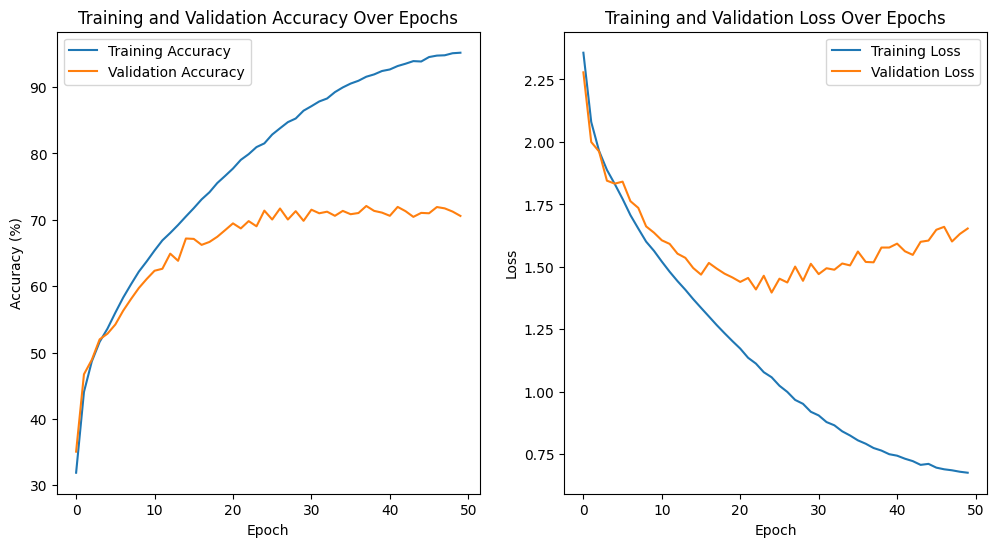

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 5.0 Evaluate the Model

In [ ]:
from sklearn.metrics import accuracy_score

student_model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = student_model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

test_accuracy = accuracy_score(y_true, y_pred) * 100
print(f'Test Accuracy: {test_accuracy:.2f}%')

print('\nClassification Report:')
print(classification_report(y_true, y_pred))

Test Accuracy: 71.10%

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.65      0.73       514
           1       0.86      0.78      0.82       490
           2       0.60      0.61      0.61       496
           3       0.48      0.53      0.50       483
           4       0.65      0.72      0.68       521
           5       0.57      0.72      0.64       489
           6       0.76      0.83      0.79       508
           7       0.84      0.64      0.72       499
           8       0.81      0.85      0.83       494
           9       0.83      0.78      0.80       506

    accuracy                           0.71      5000
   macro avg       0.72      0.71      0.71      5000
weighted avg       0.72      0.71      0.71      5000

